In [4]:
import torch.utils.data as data
from PIL import Image
import os
import os.path
import torch
import numpy as np
import torchvision.transforms as transforms
import argparse
import time
import random
import numpy.ma as ma
import copy
import scipy.misc
import scipy.io as scio
from lib.proj_utils import *
from lib.transformations import translation_matrix, quaternion_matrix, quaternion_from_matrix
import quaternion as qua
from so3_data import *

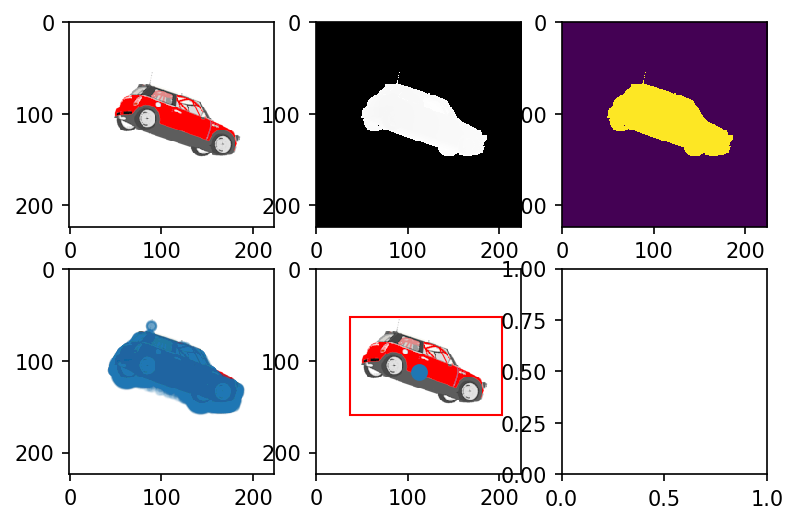

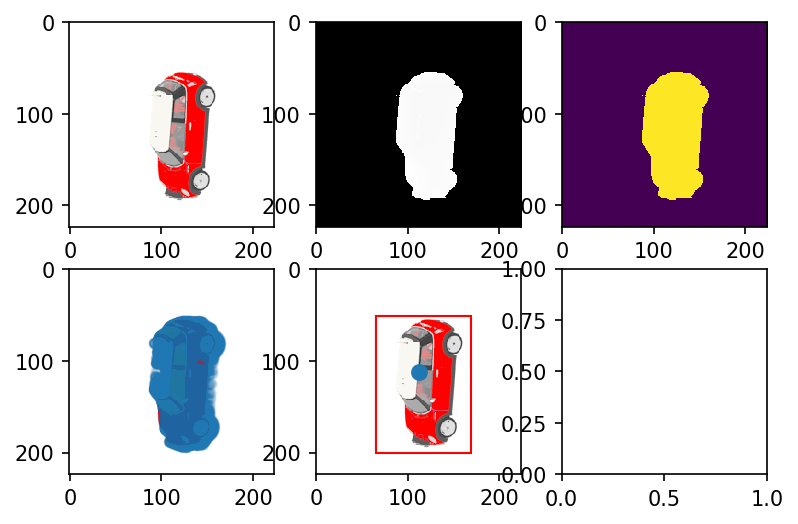

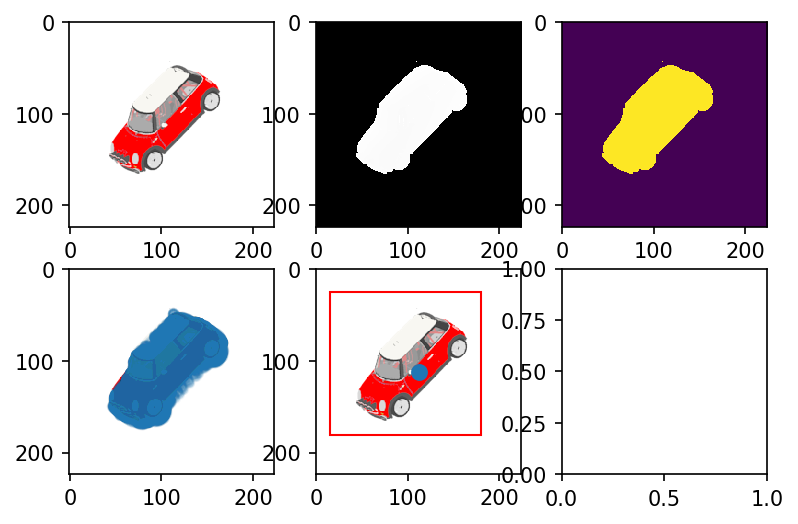

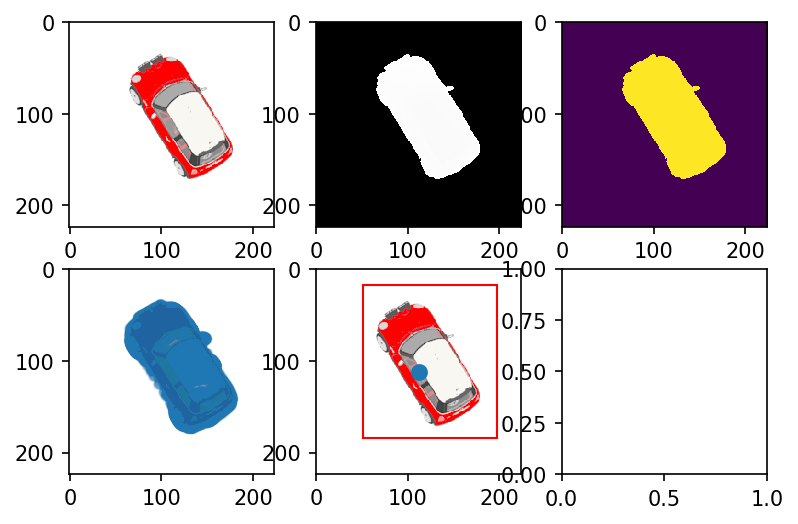

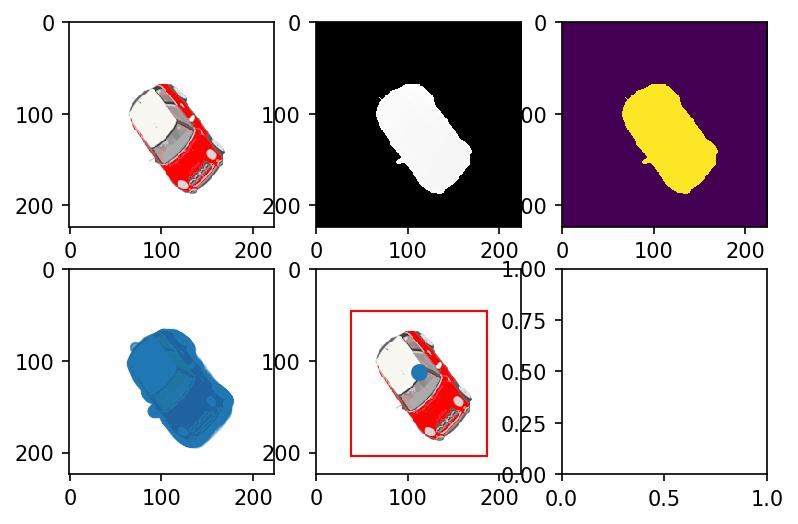

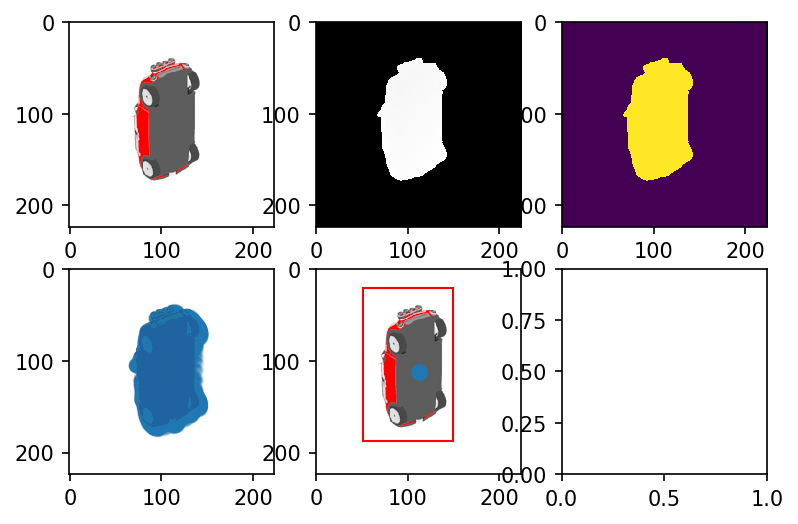

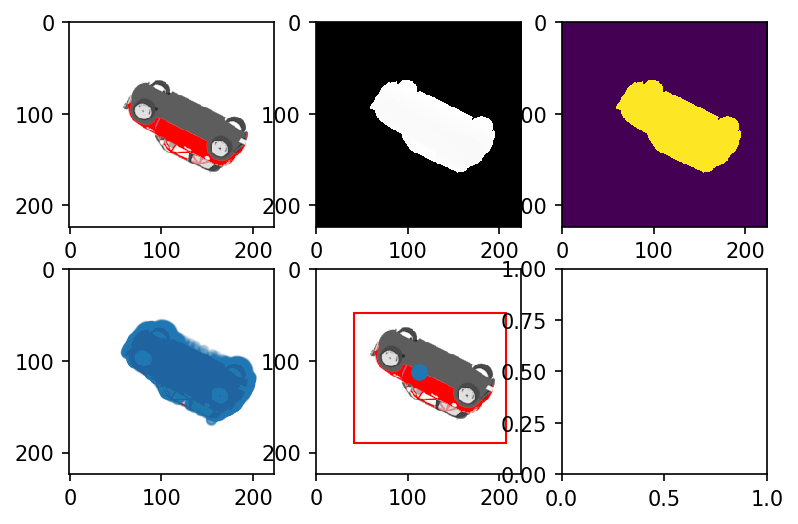

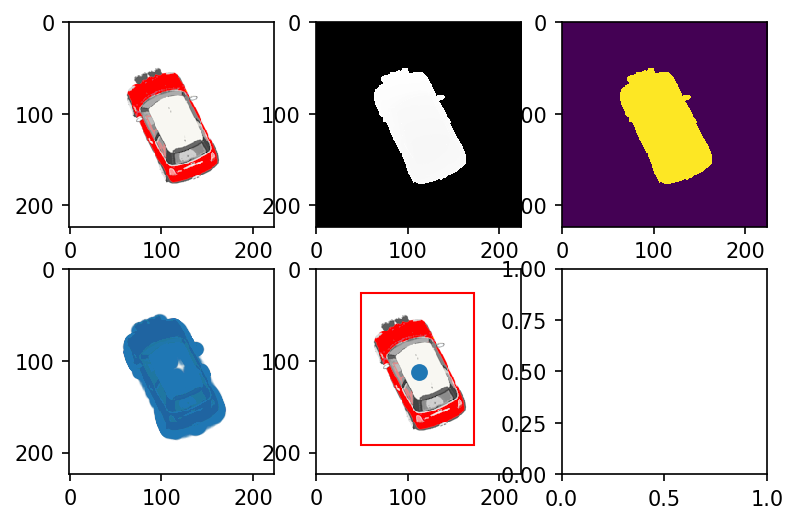

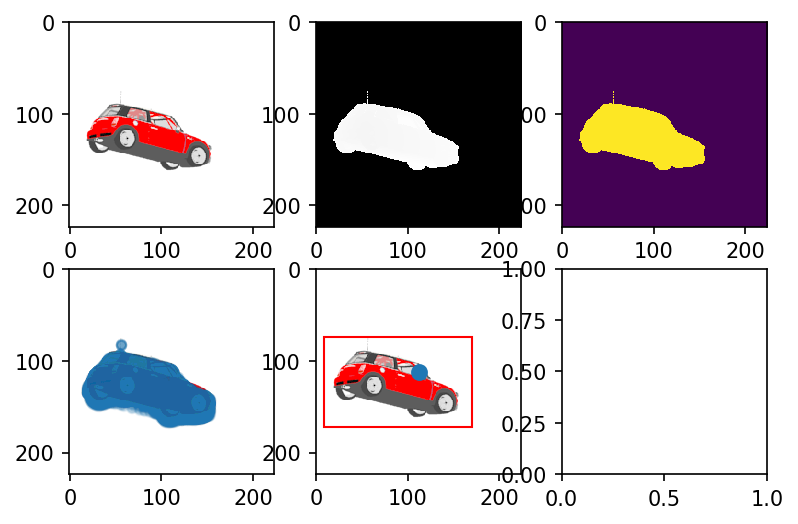

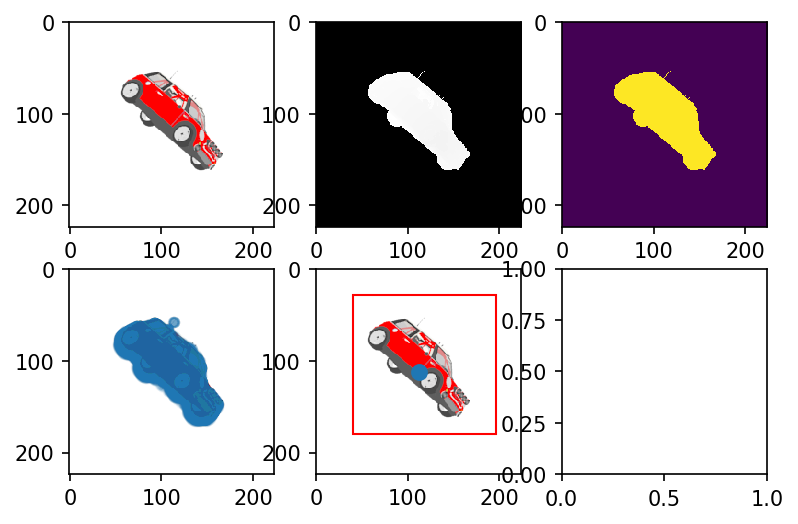

In [11]:
cat = "car"
data_dir = "/hdd/zen/dev/6dof/6dof_data/so3/small/"
# data_dir = "/home/qiaog/courses/16720B-project/SO3/data"
model_index = "0000"
index = 10
cld = read_pointxyz( os.path.join(data_dir, cat +"_ycb", "models"))
for index in range(1):
    value, boxes, img_color, depth_img, semantic = diplay_gen_ycb(cat, data_dir, cld, model_index, index)

400
100


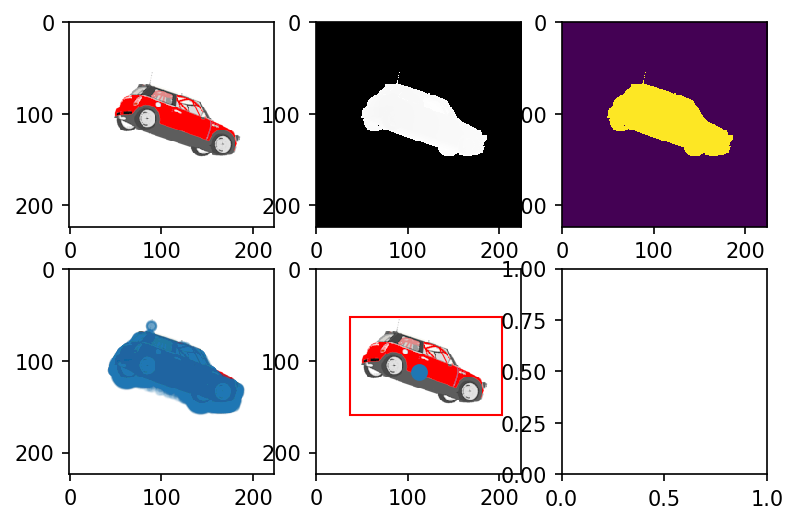

In [6]:
import matplotlib.pyplot as plt
dataset_root = "/hdd/zen/dev/6dof/6dof_data/so3/small/car_ycb/"
# dataset_root = "/home/qiaog/courses/16720B-project/SO3/data/car_ycb"
transform=transforms.Compose([transforms.ToTensor()])
train_dataset = PoseDataset('train', dataset_root, transforms=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=1)

test_dataset = PoseDataset('test', dataset_root, transforms=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=1)




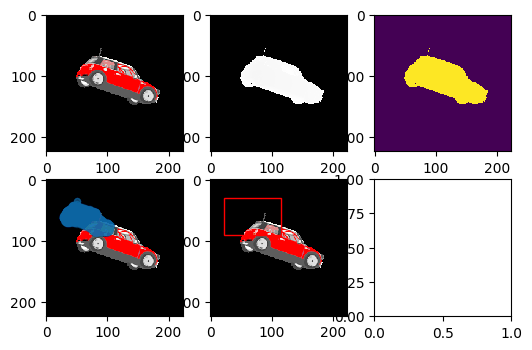

In [27]:
## Data inspection 
for i, d in enumerate(train_loader, 0):
    img, depth, boxes2d, boxes3d, label, pose_r, pose_t, pose, cam,idx= d
#     for i in range(2, 3):
    for i in range(img.shape[0]):
        display_load_img(img[i], depth[i], boxes2d[i][0], label[i], cam[i], pose_t[i], pose_r[i], pose[i], train_dataset.models[idx[i]])
#         print(np.linalg.det(pose[i][:3,:3]), i)
#         print("------------------------------------------------------------------------------------------")
        break
    break



In [203]:
%matplotlib widget
# %matplotlib inline

In [204]:
blender_cam = np.matrix([[1, 0, 0],
[0, -1, 0],
[0, 0, -1]])

blender_left = np.matrix([[1, 0, 0],
[0, 0, 1],
[0, 1, 0]])

In [205]:
# Data Training loop 
# for i, data in enumerate(train_loader, 0):
#     img, depth, boxes, label, pose_r, pose_t,  cam,idx= data
#     print(pose_r.shape)
#     quat = quaternion_from_matrix(pose_r)
#     break
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.invert_zaxis()
pts = np.copy(cld['0001'])
point3d = np.matrix.transpose(np.hstack((np.matrix(pts), np.ones(len(pts)).reshape(-1, 1))))
ax.scatter(point3d[0,:], point3d[2,:], point3d[1,:])
ax.set_xlabel('X Label')
ax.set_ylabel('Z Label')
ax.set_zlabel('Y Label')

plt.show()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pts = np.copy(cld['0001'])
point3d = np.matrix.transpose(np.hstack((np.matrix(pts), np.ones(len(pts)).reshape(-1, 1))))
iden_rot = np.identity(4)[:3,:]

iden_rot[:3, :3] = pose[i][:3,:3]
# ax.invert_zaxis()
point3d_ref = np.matmul(iden_rot, point3d)
ax.scatter(point3d_ref[0,:], point3d_ref[2,:], point3d_ref[1,:])
ax.set_xlabel('X Label')
ax.set_ylabel('Z Label')
ax.set_zlabel('Y Label')
plt.show()

FigureCanvasNbAgg()

FigureCanvasNbAgg()

In [206]:
def comp_rog(rog1, rog2):
    a1 = np.linalg.norm(rog1)
    a2 = np.linalg.norm(rog2)    
    v1 = rog1/a1
    v2 = rog2/a2
    dist = np.linalg.norm(v1 - v2)
    ang_dist = np.abs(a1 - a2)
    return dist + ang_dist

rog1 = cv2.Rodrigues(pose[0][:3,:3].numpy())[0]
rog2 = cv2.Rodrigues(pose[1][:3,:3].numpy())[0]
comp_rog(rog1, rog2)

0.42429438

In [207]:
def comp_rotation(points, rot1, rot2):
    pt1_proj = rot1.dot(points)
    pt2_proj = rot2.dot(points)
    distance = np.sum(np.linalg.norm(pt1_proj - pt2_proj, axis=0))
    return distance 

points =  np.copy(cld['0001']).T
rot1 = pose[0][:3,:3].numpy()
rot2 = pose[3][:3,:3].numpy()
comp_rotation(points, rot1, rot2)

20194.196052696872

In [208]:

for k, pts in cld.items():
    # pts = cld['0001']
    plt.axis('square')
    iden_rot = np.identity(4)[:3,:]
    iden_rot[:, 3] = pose[i][:,3]
    pts2d = project_to_img(cam[i], pose[i], pts)
#     pts2d = project_to_img(cam[i], iden_rot, pts)
    plt.scatter(pts2d[0,:], pts2d[1,:])
    plt.xlim(0, 120)
    plt.ylim(0, 120)
#     plt.gca().invert_yaxis()

    plt.show()

NotImplementedError: It is not currently possible to manually set the aspect on 3D axes